In [1]:
import torch
from src.k_tree import Ktree
from src.k_tree_ls import Ktree as Ktree_ls
from src.utils.objects.squares import loadData as loadSquares
from src.metrics import Linf_simple
from src.utils import plot_tools as pt
from src.utils import accuracy as acc

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

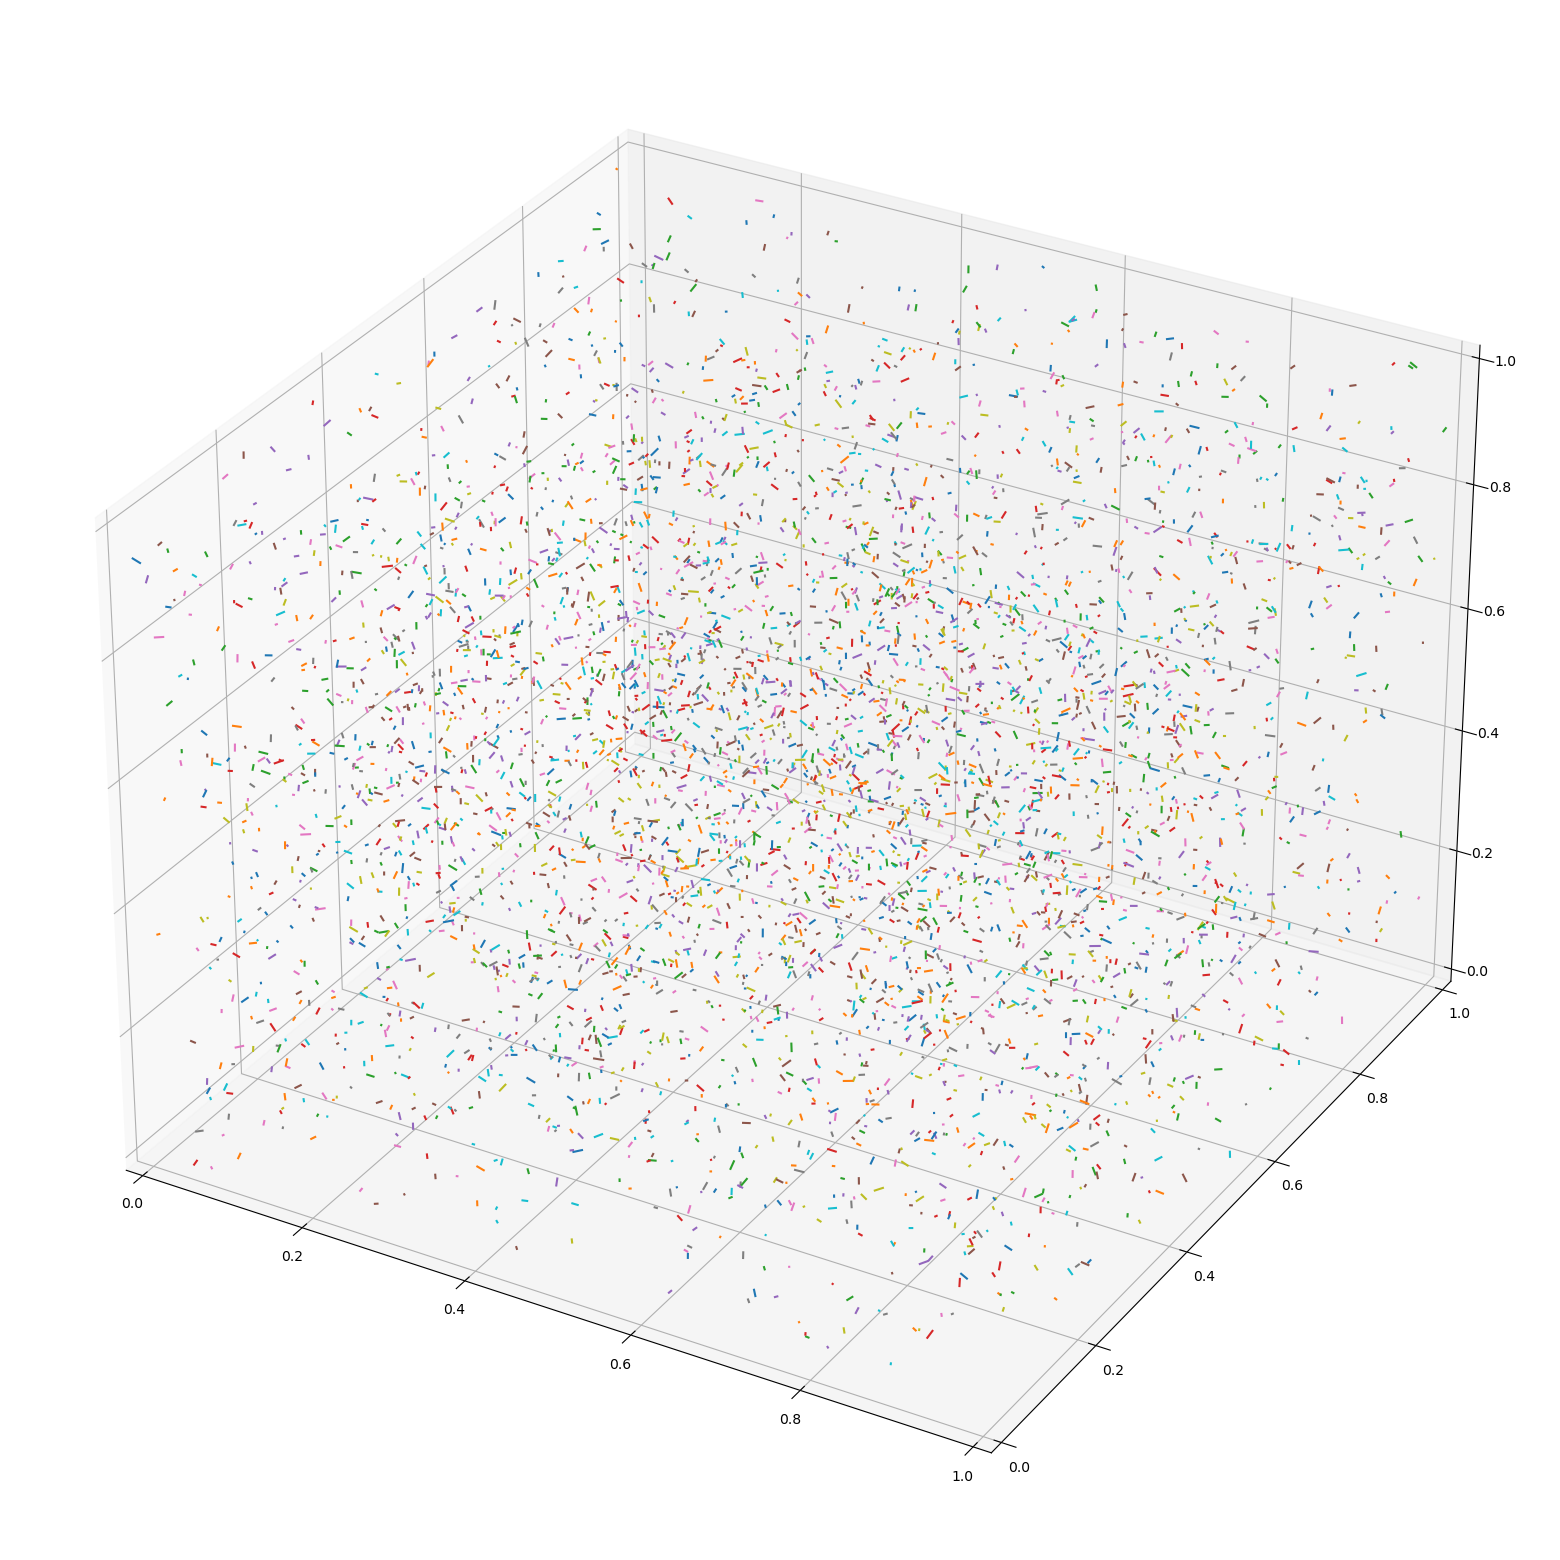

In [4]:
# create 3D line_segments
# n = 10000
# lim = 50000
# var = 500
n = 5000
lim = 1e5
var = 1000
var_ = 1
norm = lim
lim = lim / norm
var = var / norm
var_ = var_ / norm

bbox = [0, lim, 0, lim, 0, lim]
length_size = [var_, var]
theta_size = [0, 180]
phi_size = [0, 360]


def create_line_segments_3d(n, bbox, length_size, theta_size, phi_size):
    line_segments = torch.zeros((n, 6))  # ls = [x0,y0,z0, l, theta, phi]
    for i in range(n):
        x0 = torch.rand(1) * (bbox[1] - bbox[0]) + bbox[0]
        y0 = torch.rand(1) * (bbox[3] - bbox[2]) + bbox[2]
        z0 = torch.rand(1) * (bbox[5] - bbox[4]) + bbox[4]
        l = torch.rand(1) * (length_size[1] - length_size[0]) + length_size[0]
        theta = torch.rand(1) * (theta_size[1] - theta_size[0]) + theta_size[0]
        theta = torch.deg2rad(theta)
        phi = torch.rand(1) * (phi_size[1] - phi_size[0]) + phi_size[0]
        phi = torch.deg2rad(phi)
        line_segments[i, :] = torch.cat([x0, y0, z0, l, theta, phi])
    return line_segments


data = create_line_segments_3d(n, bbox, length_size, theta_size, phi_size)
# make the points
data_points = torch.zeros((n, 6))
for i in range(n):
    data_points[i, 0] = data[i, 0]
    data_points[i, 1] = data[i, 1]
    data_points[i, 2] = data[i, 2]
    data_points[i, 3] = data[i, 0] + data[i, 3] * torch.sin(data[i, 4]) * torch.cos(
        data[i, 5]
    )
    data_points[i, 4] = data[i, 1] + data[i, 3] * torch.sin(data[i, 4]) * torch.sin(
        data[i, 5]
    )
    data_points[i, 5] = data[i, 2] + data[i, 3] * torch.cos(data[i, 4])
data3d = data

# lets plot them as 3d lines using matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# make figsize big
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection="3d")
for i in range(n):
    ax.plot(
        [data_points[i, 0], data_points[i, 3]],
        [data_points[i, 1], data_points[i, 4]],
        [data_points[i, 2], data_points[i, 5]],
    )
ax.set_xlim([bbox[0], bbox[1]])
ax.set_ylim([bbox[2], bbox[3]])
ax.set_zlim([bbox[4], bbox[5]])
plt.show()

In [6]:
import torch
from src.k_tree import Ktree
from src.k_tree_ls import Ktree as Ktree_ls
from src.utils.objects.squares import loadData as loadSquares
from src.metrics import Linf_simple
from src.utils import plot_tools as pt
from src.utils import accuracy as acc

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
# lets generate #n line segments inside a bbox
# n = 100
# bbox = [0, 1000, 0, 1000]  # bbox
# length_size = [0.1, 100]  # length of the line segment
# theta_size = [0, 180]  # angle of the line segment


# # line segments will be [x0,y0,l,theta]
# # sample x0,y0 inside bbox
# def create_line_segments(n, bbox, length_size, theta_size):
#     print(f"Creating {n} line segments")
#     x0 = torch.rand(n) * (bbox[1] - bbox[0]) + bbox[0]
#     y0 = torch.rand(n) * (bbox[3] - bbox[2]) + bbox[2]
#     print(f"x0 shape: {x0.shape}")
#     # sample l inside length_size
#     l = torch.rand(n) * (length_size[1] - length_size[0]) + length_size[0]
#     print(f"l shape: {l.shape}")
#     # sample theta inside theta_size
#     theta_size = torch.rand(n) * (theta_size[1] - theta_size[0]) + theta_size[0]
#     print(f"theta shape: {theta_size.shape}")
#     theta_size = torch.deg2rad(theta_size)
#     return torch.stack([x0, y0, l, theta_size], dim=1)


# data = create_line_segments(n, bbox, length_size, theta_size)
# print(f"Data shape: {data.shape}")
# # first make data from embedding to datapoints
# data_points = torch.zeros(n, 4)
# data_points[:, 0] = data[:, 0]
# data_points[:, 1] = data[:, 1]
# data_points[:, 2] = data[:, 0] + data[:, 2] * torch.cos(data[:, 3])
# data_points[:, 3] = data[:, 1] + data[:, 2] * torch.sin(data[:, 3])
# print(f"Data points shape: {data_points.shape}")
# data2d = data

dim = 3  # space dimension

k = 3  # number of centroids to generate in the Clustering model
clustering_args = {
    "epochs": 10,  # number of epochs
    "pre_processing": 10,
    "number_of_centroids": k,  # number of centroids to generate in the Clustering model
    "dimension": dim,  # space dimension
}
n = 30
un_args = {
    "N": n,  # number of points to sample
    "M": n**3 - 1,  # number of points to return
    "epsilon": 0.15,  # the epsilon ball
}
critic_args = {
    "optimizer_lr": 5e-3,  # optimiser learning rate
    "epochs": 2000,  # number of epochs
    "width": 300,  # width of the model's linear layers
    "depth": 5,  # depth of the model's linear layers
}

threshold = 100 * k  # if a tree node has data less than the threshold, stop division

# Initialise the k-tree structure.
from src.metrics import compute_distances_3d

# pass data to the k-tree
distance_function = compute_distances_3d
ktree = Ktree_ls(
    threshold,
    data,
    distance_function,
    clustering_args,
    un_args,
    critic_args,
    device,
    dim,
)
# pass data to device
data = data.to(device)
print("Starting to create the tree...")
print("=" * 20)
ktree.create_tree(save_path_prefix="./models/line_segments/3d/5k/", plot=False)

Starting to create the tree...

Creating critic for node 0 that has 5000 data, which is more than the threshold 300.
Bounding box for node 0: tensor([[-0.0092,  1.0076],
        [-0.0067,  1.0086],
        [-0.0069,  1.0087]], device='cuda:0')
Creating clustering for node 0 with 3 centroids.
Initial divergence: 2205.05810546875
Iteration 1, divergence: 2205.05810546875
Iteration 2, divergence: 1904.0423583984375
Iteration 3, divergence: 1893.0712890625
Iteration 4, divergence: 1886.887939453125
Iteration 5, divergence: 1895.7271728515625
Iteration 6, divergence: 1902.815185546875
Iteration 7, divergence: 1899.18994140625
Iteration 8, divergence: 1898.7738037109375
Iteration 9, divergence: 1890.56103515625
Iteration 10, divergence: 1884.891845703125
getUncertaintyArea
Centroids are [[0.3881897  0.29052168 0.3173983 ]
 [0.39830843 0.5828613  0.53098303]
 [0.72725993 0.6272643  0.6534516 ]]
scale is 1.0167515277862549
dx is 1.0167515277862549, dy is 1.0153449773788452, dz is 1.01568007469

KeyboardInterrupt: 

In [ ]:
import numpy as np

# np.random.seed(0)
n = 100
random_points = torch.zeros(n, ktree.dim)
space = ktree.root.get_bounding_box().to("cpu")  # get the bounding box of the tree
for i in range(n):
    random_points[i] = torch.tensor(
        # [np.random.uniform(space[d][0], space[d][1]) for d in range(ktree.dim)]
        [
            torch.rand(1) * (space[d][1] - space[d][0]) + space[d][0]
            for d in range(ktree.dim)
        ]
    )
# pass points on device
# make them torch
random_points = random_points.to(device)
st_acc = ktree.get_critic_accuracies(random_points)

print(st_acc)

In [ ]:
acc.random_queries(ktree, n=100, times=3, k=2)
# acc.serialised_queries(ktree, n=10, k=3)